<span style="font-size: 5em">🦜</span>

# __LangGraph Essentials__
## Lab 2: Parallel Execution
<div style="display:flex; align-items:flex-start;">
  <img src="../assets/Parallel.png" width="300" style="margin-right:15px;"/>
</div>

LangGraph enables parallel execution when a node has multiple outgoing edges. This notebook demonstrates how to build graphs with branching paths that execute simultaneously and then converge. We will use the operator.add reducer to accumulate results from parallel branches.


So an edge passes control from one node to the next.

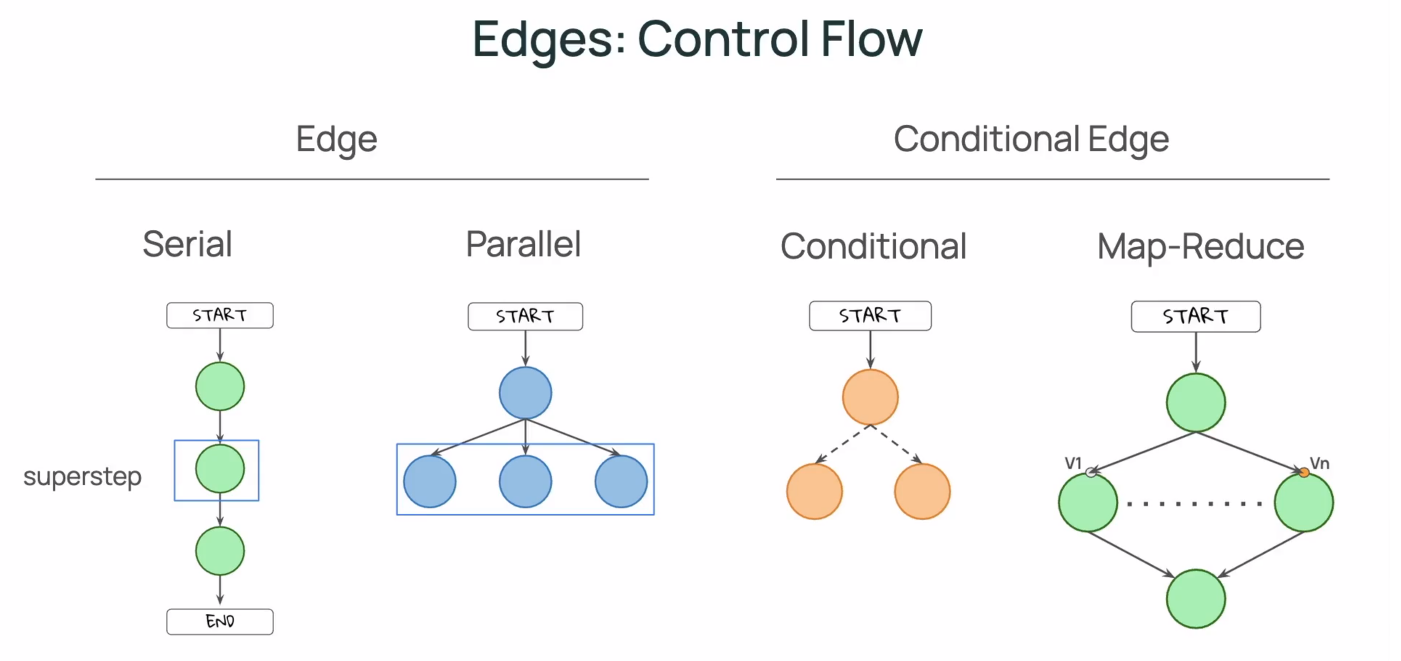

1. In the serial case, at the end of the first step, the LangGrapgh runtime will initialize and run that second node.

2. in the parallel case, all three of the following nodes will actually be run in parallel. because multiple steps can be run simultaneously, these steps from node to node are called Super Steps (In Serial case and parallel case)

3. The examples of Serial case and Parallel case have static edges, which means they will always be taken.

4. In the diagram, conditional edges are rendered as dashed lines. Conditional edges are powerful because they allow for decision making, where control is passed to a node based on a condition.

5. A special case of conditional edge is MapReduce, where a variable number of downstream nodes are created and each passed a unique value.

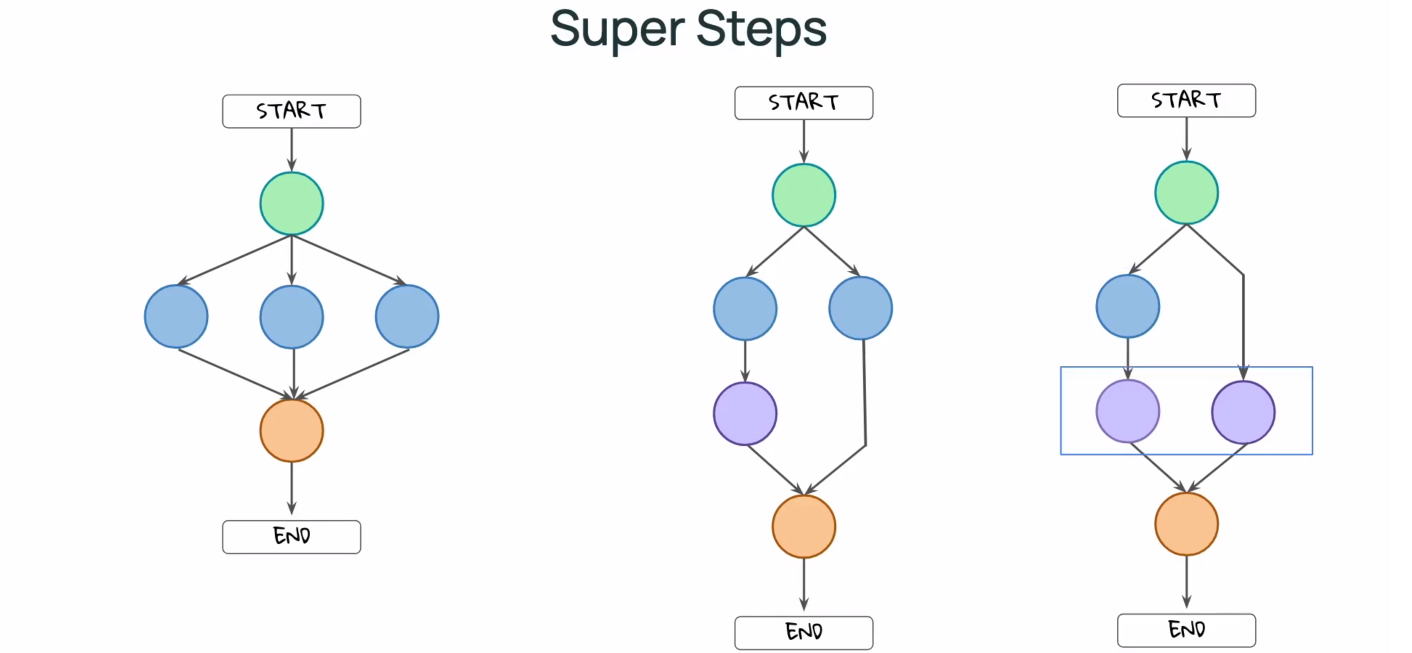

1. We described the idea of a Super Step, where all active nodes in a step have completed and stored their values to state before continuing onto the next node.

2. Here, the input state to the orange node is the result of all of the updates by the blue nodes. (1st diagram)

3. But what about situations like these (diagram 2nd and 3rd) where paths are different lengths? Well LangGrapgh allows you to specify when the right hand node executes. 

4. Normally right hand nodes would activate when the green node finishes. Normally right hand nodes would activate when the green node finishes. Its output is then available as an input to the purple nodes.

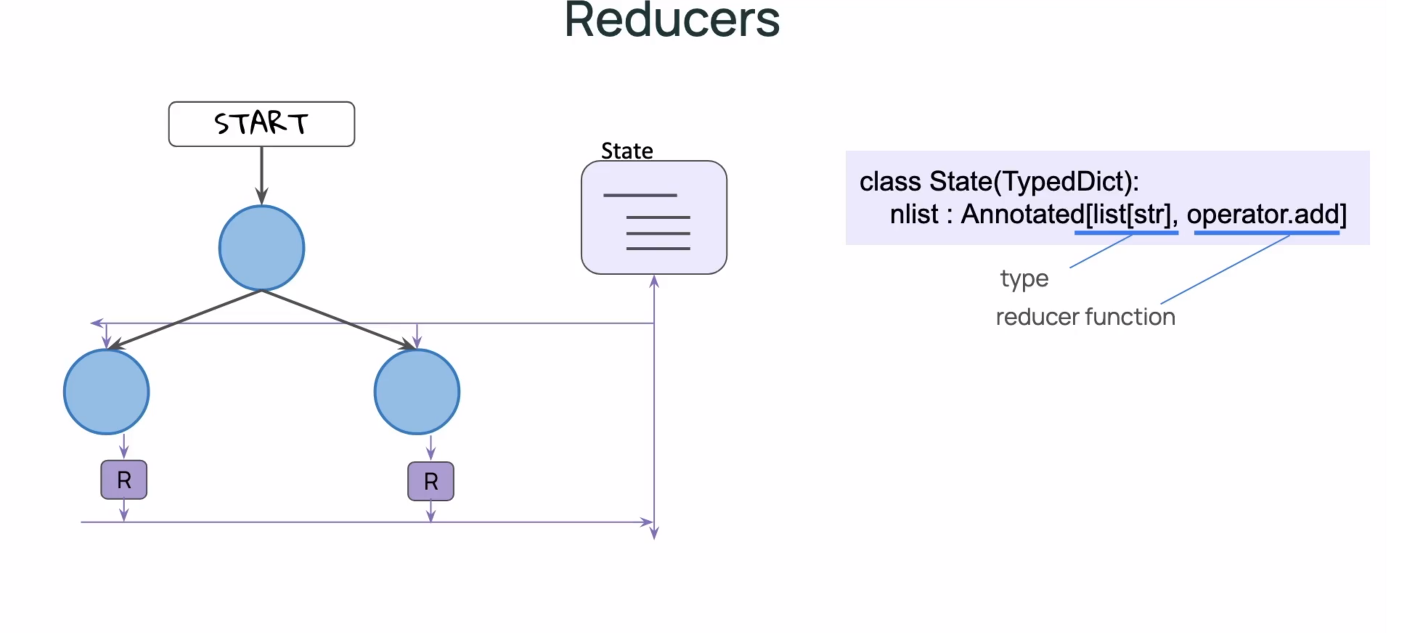

1. At the beginning of the step, nodes are provided with the current state, and after they execute, they will update the shared state. But what happens when all the nodes return an update to the nlist property of our state? Well, by default the value written last would overwrite the previous state, as we saw in our very first lab.

2. To solve this, we can introduce reducer function. The name comes from the general term MapReduce, and this special function allows us to define how we want to handle many writes to the same state key.

3. When state values are updated at the end of the node execution, LangGrapgh can use the provider function for that key to decide how the state should be executed.

4. In the given example diagram, the values are appended to the list, rather than simply overwriting the previous value because we have set our reducer function to be operator dot add.
>>> class State(TypedDict):
    nlist : Anootated[list[str], operator.add] #1st arg is type of the variable and 2nd variable is the metadata, and LangGraph uses that to specify the reducer operation(operator.add).

5. Now this reducer function is actually up for us to define.

This is the diagram in the slide
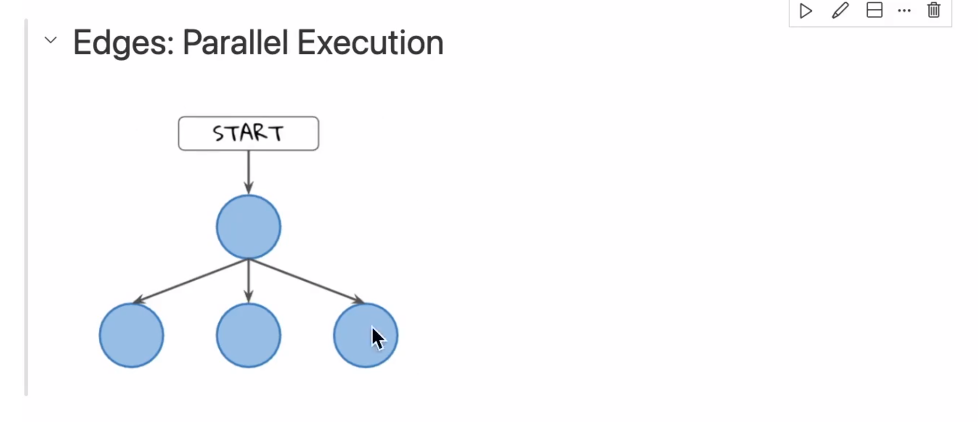

Here we have 3 nodes at the bottom which executes in parallel.

### We are going to build this below grapgh in this notebook
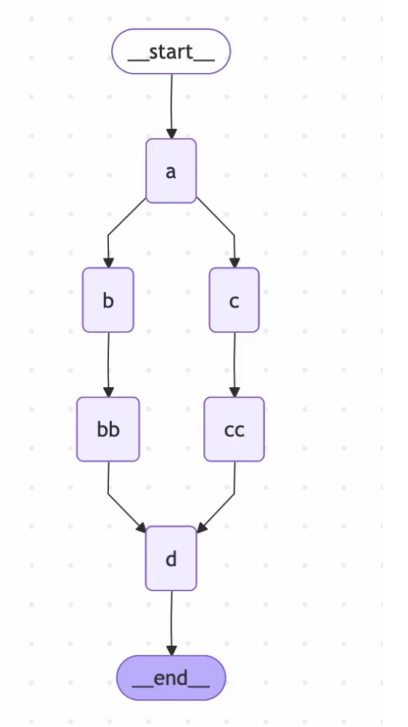

In [1]:
from IPython.display import Image, display
import operator
from typing import Annotated, List, Literal, TypedDict
from langgraph.graph import END, START, StateGraph
from langgraph.types import Command, interrupt

<a id='state_with_reducer'></a>


In [3]:
class State(TypedDict):
    nlist: Annotated[List[str], operator.add] 

#Opertor.add will concatenate all list updates in the state

<a id='parallel_nodes'></a>


In [4]:
# We will define nodes where each nodes receives state, print its Name and Input, and 
# return its own label as an update to nlist
def node_a(state: State) -> State:
    print(f"Adding 'A' to {state['nlist']}")
    return(State(nlist = ["A"]))

def node_b(state: State) -> State:
    print(f"Adding 'B' to {state['nlist']}")
    return(State(nlist = ["B"]))

def node_c(state: State) -> State:
    print(f"Adding 'C' to {state['nlist']}")
    return(State(nlist = ["C"]))

def node_bb(state: State) -> State:
    print(f"Adding 'BB' to {state['nlist']}")
    return(State(nlist = ["BB"]))

def node_cc(state: State) -> State:
    print(f"Adding 'CC' to {state['nlist']}")
    return(State(nlist = ["CC"]))

def node_d(state: State) -> State:
    print(f"Adding 'D' to {state['nlist']}")
    return(State(nlist = ["D"]))

<a id='parallel_graph'></a>


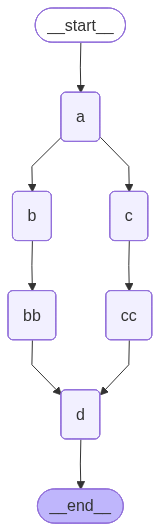

In [5]:
#Here we build our graph
#So first we instantiate stategraph with our state.
builder = StateGraph(State)

# Add nodes
builder.add_node("a", node_a)
builder.add_node("b", node_b)
builder.add_node("c", node_c)
builder.add_node("bb", node_bb)
builder.add_node("cc", node_cc)
builder.add_node("d", node_d)

# Add edges
builder.add_edge(START,"a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "bb")
builder.add_edge("c", "cc")
builder.add_edge("bb", "d")
builder.add_edge("cc", "d")
builder.add_edge("d",END)

# Compile and display
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

<a id='parallel_execution'></a>


In [6]:
initial_state = State(
    nlist = ["Initial String:"]
)
graph.invoke(initial_state)

Adding 'A' to ['Initial String:']
Adding 'B' to ['Initial String:', 'A']
Adding 'C' to ['Initial String:', 'A']
Adding 'BB' to ['Initial String:', 'A', 'B', 'C']
Adding 'CC' to ['Initial String:', 'A', 'B', 'C']
Adding 'D' to ['Initial String:', 'A', 'B', 'C', 'BB', 'CC']


{'nlist': ['Initial String:', 'A', 'B', 'C', 'BB', 'CC', 'D']}

In the above output, you see, Adding 'BB' to ['Initial String:', 'A', 'B', 'C']
Where you might have not expected 'C' as 'C' was in different parallel branch than 'BB' but it is there.

Reason:
Edges define control flow, but they do not control the data that nodes have access to.
So when a node runs, it will have access to the current graph state, even if this state includes values written on parallel branches.

So in other words, BB has access to state updates made by node B, but also by node C. Similarly CC has access to state updates made by node B and node C, as well as node A for both of the cases.

Takeways:
1. When setting yp state, we have l;earned that you can use a reducer function in the state definition to influence how state is accumulated.

2. During execution, nodes B and C execute in parallel. Our graph uses the reducer function to merge the values returned from each node, then the results from nodes B and C store to state before starting nodes BB and CC.

## Takeaways

Setup:

- State: You added a [reducer function](#state_with_reducer) in the state definition using Annotated with operator.add
- Graph: You used [add_edge()](#parallel_graph) to create parallel paths from node 'a' to both 'b' and 'c'

Execution:

- Runtime: [Nodes b and c](#parallel_nodes) operate in parallel, executing simultaneously
- The reducer function merges the values returned from parallel branches
- Results from node b and c are stored to state before starting node bb and cc

Result:

- The [final result](#parallel_execution) contains all values added to `nlist` by all nodes
- Values accumulate in the order nodes complete execution

Try Next:

- Try adding a 3rd parallel path from node 'a'
- Rather than joining at d, have bb and cc pass control to END. Are values still merged?
- Change the reducer from operator.add to a different function to see how state merging changes